# Example of parallel Proper Orthogonal Decomposition
This notebook is an example on how to perform proper orthogonal decomposition in parallel using pyLOM. First of all, let's import the needed libraries

In [1]:
from __future__ import print_function, division

import mpi4py
mpi4py.rc.recv_mprobe = False

import numpy as np
import pyLOM

0 Warning! Import - NVTX not present!


Then we will detect the GPU configuration of our hardware to check if we can run the POD on the GPU or we have to use CPUs. In case we are using GPUs, we need to specify how many GPUs are available on our machine or on each computing node of our cluster

In [2]:
pyLOM.gpu_device(gpu_per_node=4)

0 Warning! cupy not available! GPU version deactivated!


Now it's time to specify the path to the pyLOM dataset from which we'll be loading the data to perform POD and the variable we will decompose. Although all pyLOM functionalities need a np.ndarray as input argument, it is highly recommended to the data using the pyLOM dataset format because it manages the data in parallel straightaway

In [3]:
## Parameters
DATAFILE = '../../../Testsuite/DATA/CYLINDER.h5'
VARIABLE = 'VELOC'

## Data loading
m = pyLOM.Mesh.load(DATAFILE)
d = pyLOM.Dataset.load(DATAFILE,ptable=m.partition_table).to_gpu([VARIABLE]) # Send to GPU if available
X = d[VARIABLE]
t = d.get_variable('time')

The next step is already performing the proper orthogonal decomposition of the array X. In this case we activate the flag to mean-center the data before doing POD and we'll compute the full matrices as it is the default option from pyLOM:

In [4]:
PSI,S,V = pyLOM.POD.run(X,remove_mean=True)

Now, we can truncate the POD matrices depending on the singular values which we want to keep. We can use three different truncation criteria as the smallest singular value that we want to mantain, how many modes we want the reduced system to keep or the energy percentage that we want to conserve.  If r >= 1, it is treated as the number of modes, if r < 1 and r > 0 it is treated as the residual target and finally if r < 1 and r < 0 it is treated as the fraction of cumulative energy to retain.
In this case we'll retain all the modes with a singular value larger than 5e-6.

In [5]:
PSI,S,V = pyLOM.POD.truncate(PSI,S,V,r=5e-6)

Instead of computing the full POD matrices and then truncate the results, we can also perform randomized POD straightaway to save some computational time and memory resources. To do so, we must activate the randomized flag of the POD.run function, specify the number of modes that we want to compute and the number of power iterations (recommended between 1 and 3). 

In [6]:
PSI,S,V = pyLOM.POD.run(X,remove_mean=True,randomized=True,r=8,q=3) # PSI are POD modes

After that we can reconstruct the data using the truncated or randomized modes to assess the effect of reducing the number of modes on the total flow field dynamics

In [7]:
X_POD = pyLOM.POD.reconstruct(PSI,S,V)
mean   = pyLOM.math.temporal_mean(X)
X_PODm = pyLOM.math.subtract_mean(X_POD, -1*mean)
rmse  = pyLOM.math.RMSE(X_PODm,X)
pyLOM.pprint(0,'RMSE = %e'%rmse)

RMSE = 3.572839e-05


The spatial modes can then be visualized using either pyVista (when working locally and in serial) or saved to a vtkhdf file that can be read using ParaView. The first step is adding the spatial modes as a new variable to the pyLOM dataset:

In [8]:
d.add_field('spatial_modes_U',6,pyLOM.POD.extract_modes(PSI,1,len(d),modes=[1,4,6,2,5,3]))

And then save them in ParaView format

/home/benet/.local/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


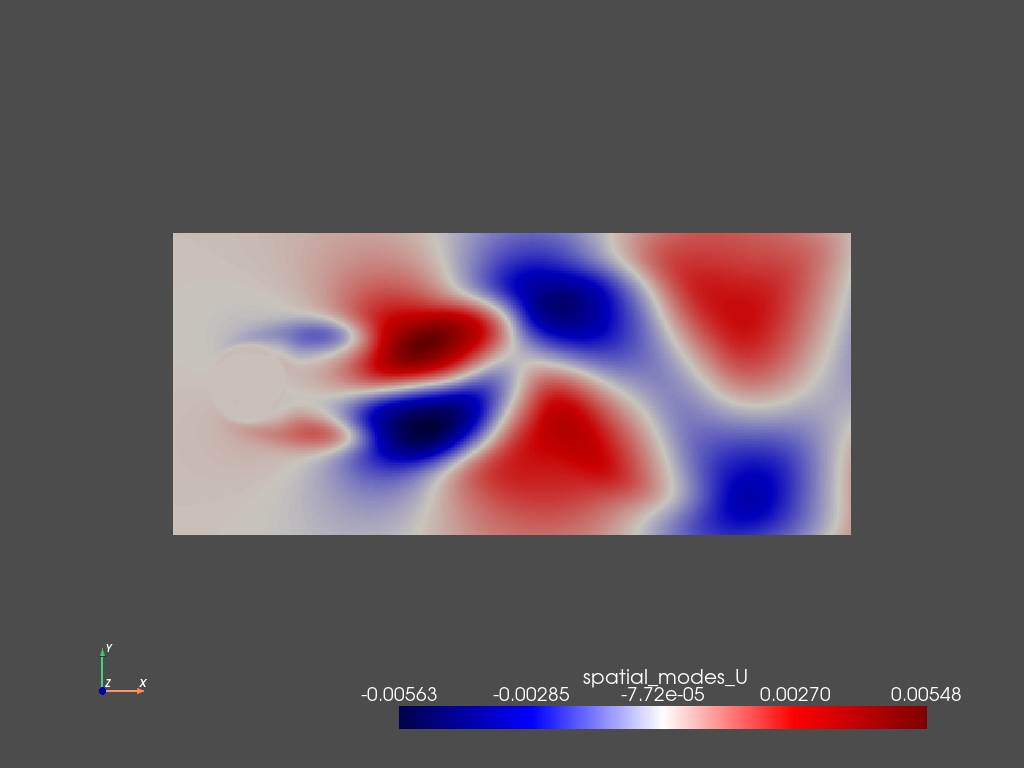

In [9]:
pyLOM.io.pv_writer(m,d.to_cpu(['spatial_modes_U']),'modes',basedir='out/modes',instants=[0],times=[0.],vars=['spatial_modes_U'],fmt='vtkh5')
pyLOM.POD.plotSnapshot(m,d.to_cpu(['spatial_modes_U']),vars=['spatial_modes_U'],instant=0,component=0,cmap='seismic',cpos='xy')

Then we can also visualize the reconstruction using only the truncated modes using the same workflow:

/home/benet/.local/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


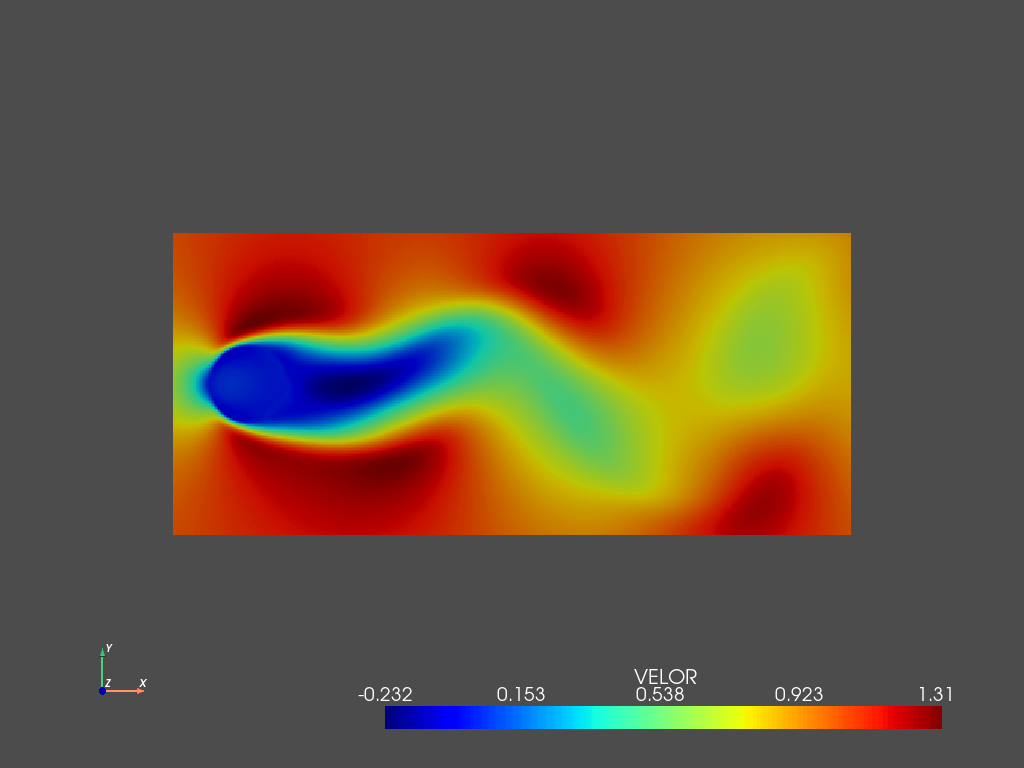

In [10]:
d.add_field('VELOR',2,X_PODm)
pyLOM.io.pv_writer(m,d.to_cpu(['VELOC','VELOR']),'flow',basedir='out/flow',instants=np.arange(t.shape[0],dtype=np.int32),times=t,vars=['VELOC','VELOR'],fmt='vtkh5')
pyLOM.POD.plotSnapshot(m,d.to_cpu(['VELOR']),vars=['VELOR'],instant=0,component=0,cmap='jet',cpos='xy')